In [1]:
import os
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from openpyxl.utils import get_column_letter
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary

In [6]:
ruta_carpeta = "/Users/Usuario/OneDrive/Escritorio/tfg/probeta 1/"
num_ensayos=11
nombres_archivos = [f"ENSAYO_{i}.xlsx" for i in range(num_ensayos)]

# Intervalo de frecuencias de cada canal
intervalo_canales = [
    (4, 804),      
    (810, 1610),   
    (1616, 2416),
    (2422, 3222),
    #(3228, 4028), Nos saltamos el sensor 5
    (4034, 4834),
    (4840, 5640),
    (5646, 6446),
    (6452, 7252),
    (7258, 8058)
]
# Definir las columnas de frecuencia, parte real y parte imaginaria para cada rango
frecuencia_col = [1, 4, 7, 10, 13, 16, 19, 22, 25]  # A, D, J
real_col = [2, 5, 8, 11, 14, 17, 20, 23, 26]  # B, E, K
imagin_col = [3, 6, 9, 12, 15, 18, 21, 24, 27]  # C, F, L
# Convertimos estas a letras para el print
frecuencia_col_letras = [get_column_letter(col) for col in frecuencia_col]
real_col_letras = [get_column_letter(col) for col in real_col]
imagin_col_letras = [get_column_letter(col) for col in imagin_col]

In [7]:
# Obtenemos las partes reales e imagin separadas por ensayo, hojas, canales y rangos
data_frecuencias = []
data_partes_reales = []
data_partes_imagin = []
for ensayo_idx, nombre_archivo in enumerate(nombres_archivos):
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    wb = openpyxl.load_workbook(ruta_archivo)

    sweep1=wb['Sweep_1']
    sweep2=wb['Sweep_2']
    sweep3=wb['Sweep_3']
    
    sweeps = [sweep1, sweep2, sweep3]
    
    if ensayo_idx == 0:  # Solo se almacena una vez porque las frecuencias no cambian entre ensayos
        for col in frecuencia_col:
            column_data = [sweeps[0].cell(row=i, column=col).value for i in range(4, 805)]
            data_frecuencias.append(column_data)

    ensayo_partes_reales = []
    ensayo_partes_imagin = []
    
    for sheet in sweeps:
        sweep_data_reales = []
        sweep_data_imagin = []
        for inicio, fin in intervalo_canales:
            canal_data_reales = []
            canal_data_imagin = []
            for col_r, col_i in zip(real_col, imagin_col):
                column_data_reales = [sheet.cell(row=i, column=col_r).value for i in range(inicio, fin + 1)]
                column_data_imagin = [sheet.cell(row=i, column=col_i).value for i in range(inicio, fin + 1)]
                canal_data_reales.append(column_data_reales)
                canal_data_imagin.append(column_data_imagin)
            sweep_data_reales.append(canal_data_reales)
            sweep_data_imagin.append(canal_data_imagin)
        ensayo_partes_reales.append(sweep_data_reales)
        ensayo_partes_imagin.append(sweep_data_imagin)
    data_partes_reales.append(ensayo_partes_reales)
    data_partes_imagin.append(ensayo_partes_imagin)

In [7]:
# Ahora, imprimir las partes reales y las imaginarias para comprobar la estructura
# print("\nPartes Reales y Partes Imaginarias:")

# Recorremos los datos de partes reales e imaginarias
# for ensayo_idx, (sweep_reales, sweep_imagin) in enumerate(zip(data_partes_reales, data_partes_imagin), start=1):
#     print(f"\nEnsayo {ensayo_idx-1}:")
#     for sweep_idx, (sweep_data_reales, sweep_data_imagin) in enumerate(zip(sweep_reales, sweep_imagin), start=1):
#         print(f"  Barrido {sweep_idx}:")
        
#         for canal_idx, (canal_reales, canal_imagin) in enumerate(zip(sweep_data_reales, sweep_data_imagin), start=1):
#             print(f"    Canal {canal_idx}:")
#             for col_idx, (column_reales, column_imagin) in enumerate(zip(canal_reales, canal_imagin), start=1):
#                 print(f"      Columna {real_col_letras[col_idx-1]}:")
#                 print(f"        Parte Real (primeros 5 valores): {column_reales[:5]}")
#                 print(f"        Parte Imaginaria (primeros 5 valores): {column_imagin[:5]}")


In [16]:
data_frecuencias_np = np.array(data_frecuencias)
data_partes_reales_np = np.array(data_partes_reales)
data_partes_imagin_np = np.array(data_partes_imagin)

In [17]:
print(data_frecuencias_np.shape)
print(data_partes_reales_np.shape)
print(data_partes_imagin_np.shape)

(9, 801)
(11, 3, 9, 9, 801)
(11, 3, 9, 9, 801)


In [18]:
data_partes_reales_np_reshaped=data_partes_reales_np.reshape(11, 3, 9, 81, 89)
data_partes_reales_np_reshaped.shape

(11, 3, 9, 81, 89)

In [19]:
data_partes_imagin_np_reshaped=data_partes_imagin_np.reshape(11, 3, 9, 81, 89)
data_partes_imagin_np_reshaped.shape

(11, 3, 9, 81, 89)

In [13]:
# #VISUALIZACIÓN DE SEÑALES: Subplots de las señales separados por sensor, carga y sensor-barrido
# n_ensayos, n_barridos, n_sensores, n_puntos = (11, 3, 9, 7209)
# colormap = plt.get_cmap("tab20")
# # Parte real
# for sensor in range(n_sensores):
#     fig, axs = plt.subplots(n_barridos, 1, figsize=(12, 8), sharex=True) # Creamos una figura con n_barridos subplots (uno por cada barrido).
#     if sensor<4:
#         fig.suptitle(f"Parte Real para Sensor {sensor+1}", fontsize=16)
#     else: fig.suptitle(f"Parte Real para Sensor {sensor+2}", fontsize=16)
    
#     # Iteramos sobre cada barrido
#     for barrido in range(n_barridos):
#         ax = axs[barrido]  
#         for ensayo in range(n_ensayos):
#             color = colormap(ensayo % 20)
#             ax.plot(data_frecuencias_np_reshaped,data_partes_reales_np_reshaped[ensayo, barrido, sensor], label=f"Ensayo {ensayo+1}", color=color)
        
#         ax.set_ylabel(f"Barrido {barrido+1}")
#         ax.legend(fontsize=8, loc="upper right")
    
#     axs[-1].set_xlabel("Frecuencia [Hz]")
#     plt.tight_layout()
#     plt.show()

In [14]:
# #Parte imaginaria
# for sensor in range(n_sensores):
#     fig, axs = plt.subplots(n_barridos, 1, figsize=(12, 8), sharex=True) # Creamos una figura con n_barridos subplots (uno por cada barrido).
#     if sensor<4:
#         fig.suptitle(f"Parte Imaginaria para Sensor {sensor+1}", fontsize=16)
#     else: fig.suptitle(f"Parte Imaginaria para Sensor {sensor+2}", fontsize=16)
    
#     # Iteramos sobre cada barrido
#     for barrido in range(n_barridos):
#         ax = axs[barrido]  
#         for ensayo in range(n_ensayos):
#             color = colormap(ensayo % 20)
#             ax.plot(data_frecuencias_np_reshaped,data_partes_imagin_np_reshaped[ensayo, barrido, sensor, :], label=f"Ensayo {ensayo+1}",color=color)
        
#         ax.set_ylabel(f"Barrido {barrido+1}")
#         ax.legend(fontsize=8, loc="upper right")
    
#     axs[-1].set_xlabel("Frecuencia [Hz]")
#     plt.tight_layout()
#     plt.show()

In [20]:
data_partes_reales_tensor = torch.tensor(data_partes_reales_np_reshaped, dtype=torch.float32)
data_partes_imagin_tensor = torch.tensor(data_partes_imagin_np_reshaped, dtype=torch.float32)
torch.save(data_partes_reales_tensor, 'tensor_emis_real_corto.pt')
torch.save(data_partes_imagin_tensor, 'tensor_emis_imagin_corto.pt')

In [21]:
data_partes_reales_tensor=torch.load('tensor_emis_real_corto.pt')
data_partes_imagin_tensor=torch.load('tensor_emis_imagin_corto.pt')


# Definición del Autoencoder Variacional (VAE)
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 3, stride=2, padding=2),
            nn.ReLU()
        )
        
       # Obtener tamaño de salida del encoder dinámicamente
        with torch.no_grad():
            sample_input = torch.randn(1, 1, 89)
            sample_output = self.encoder(sample_input)
            encoded_dim = sample_output.numel() // sample_output.shape[0]
            print(encoded_dim)

        self.fc_mu = nn.Linear(encoded_dim, latent_dim)
        self.fc_logvar = nn.Linear(encoded_dim, latent_dim)
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, encoded_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 64, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, 3, stride=2, padding=2),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplanamos
        #print(f"Tamaño después del encoder: {x.shape}")  # Depuración
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        x = self.decoder_fc(z).view(x.size(0), 64, -1)
        x = self.decoder(x)
        return x, mu, logvar

In [23]:
print(data_partes_reales_tensor.shape)
print(data_partes_imagin_tensor.shape)

torch.Size([11, 3, 9, 81, 89])
torch.Size([11, 3, 9, 81, 89])


In [24]:
latent_dim=4
model = VariationalAutoencoder(latent_dim)
summary(model, input_size=(64, 1, 89))

256


Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoencoder                   [64, 1, 89]               --
├─Sequential: 1-1                        [64, 64, 4]               --
│    └─Conv1d: 2-1                       [64, 16, 46]              64
│    └─ReLU: 2-2                         [64, 16, 46]              --
│    └─Conv1d: 2-3                       [64, 16, 24]              784
│    └─ReLU: 2-4                         [64, 16, 24]              --
│    └─Conv1d: 2-5                       [64, 32, 13]              1,568
│    └─ReLU: 2-6                         [64, 32, 13]              --
│    └─Conv1d: 2-7                       [64, 32, 8]               3,104
│    └─ReLU: 2-8                         [64, 32, 8]               --
│    └─Conv1d: 2-9                       [64, 64, 5]               6,208
│    └─ReLU: 2-10                        [64, 64, 5]               --
│    └─Conv1d: 2-11                      [64, 64, 4]               12,352
│

In [25]:
learning_rate = 1e-3 # Determina qué tan grandes son los ajustes en los parámetros del modelo después de cada lote o época.
batch_size = 64 # Es la cantidad de datos que se pasan por la red antes de actualizar los parámetros
epochs = 100 # Una época es una pasada completa por todo el dataset de entrenamiento
def loss_fn(outputs, inputs, mu, logvar,beta=0.05):
    mse = (outputs - inputs) ** 2  # Calcula el error cuadrático

    # Reducción lotes/muestras con mean
    loss_0= torch.mean(mse, dim=0)
    
    # Reducción secuencia/longitud con sum
    loss_2 = torch.sum(mse, dim=2)
    
    recon_loss = torch.sum(loss_2) + torch.sum(loss_0)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_divergence
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
baseline=data_partes_reales_tensor[[0]]
print(baseline.shape)
loads=data_partes_reales_tensor[1:]
print(loads.shape)

torch.Size([1, 3, 9, 81, 89])
torch.Size([10, 3, 9, 81, 89])


In [27]:
def scale_data(data):
    min_val = data.min()
    max_val = data.max()
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

In [28]:
# Preparar los datos para DataLoader
# Reestructurar los tensores para que tengan la forma [num_samples, num_channels, sequence_length]
baseline_scaled = scale_data(baseline.view(-1, 1, 89))
loads_scaled = scale_data(loads.view(-1, 1, 89))

print(baseline_scaled.shape)
print(loads_scaled.shape)

train_dataset = TensorDataset(baseline_scaled)
test_dataset = TensorDataset(loads_scaled)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([2187, 1, 89])
torch.Size([21870, 1, 89])


In [29]:
# Entrenamiento del modelo
def train_model(model, train_loader, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            inputs = batch[0]
            outputs, mu, logvar = model(inputs)
            loss = loss_fn(outputs, inputs, mu, logvar)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        print(f"Época {epoch+1}/{epochs}, Pérdida: {epoch_loss / len(train_loader):.6f}")

train_model(model, train_loader, optimizer, epochs)

Época 1/100, Pérdida: 374.717556
Época 2/100, Pérdida: 154.766582
Época 3/100, Pérdida: 60.154974
Época 4/100, Pérdida: 42.286919
Época 5/100, Pérdida: 36.771049
Época 6/100, Pérdida: 32.035337
Época 7/100, Pérdida: 27.732434
Época 8/100, Pérdida: 22.525629
Época 9/100, Pérdida: 12.882490
Época 10/100, Pérdida: 10.522273
Época 11/100, Pérdida: 10.868324
Época 12/100, Pérdida: 10.189056
Época 13/100, Pérdida: 9.014784
Época 14/100, Pérdida: 9.406716
Época 15/100, Pérdida: 9.268768
Época 16/100, Pérdida: 9.012152
Época 17/100, Pérdida: 8.725038
Época 18/100, Pérdida: 8.614407
Época 19/100, Pérdida: 8.546335
Época 20/100, Pérdida: 8.487308
Época 21/100, Pérdida: 8.613686
Época 22/100, Pérdida: 8.489284
Época 23/100, Pérdida: 8.511856
Época 24/100, Pérdida: 8.664325
Época 25/100, Pérdida: 8.591243
Época 26/100, Pérdida: 8.988753
Época 27/100, Pérdida: 8.831604
Época 28/100, Pérdida: 8.955977
Época 29/100, Pérdida: 8.739296
Época 30/100, Pérdida: 8.936129
Época 31/100, Pérdida: 8.905982
Épo

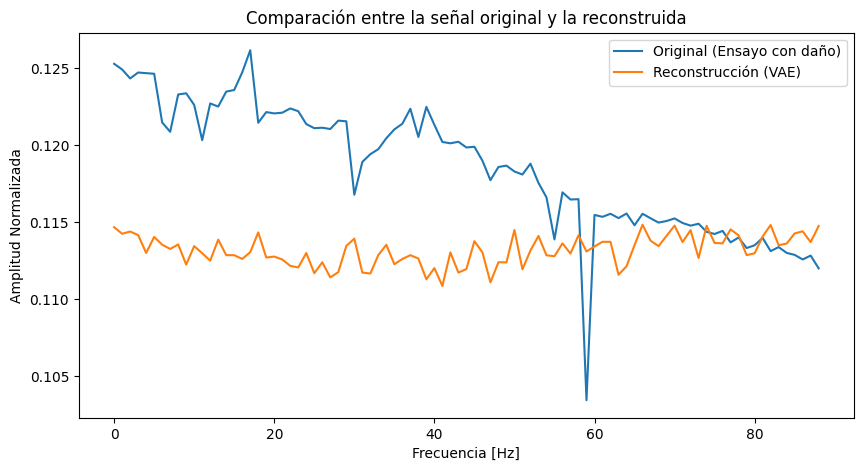

In [31]:
# Evaluación del modelo
def evaluate_model(model, loads_scaled):
    model.eval()
    with torch.no_grad():
        original_signal = loads_scaled[0]
        reconstructed_signal, _, _ = model(original_signal.unsqueeze(0))
        reconstructed_signal = reconstructed_signal.squeeze(0).squeeze(0).detach()
    
    plt.figure(figsize=(10, 5))
    plt.plot(original_signal.squeeze().numpy(), label="Original (Ensayo con daño)")
    plt.plot(reconstructed_signal.numpy(), label="Reconstrucción (VAE)")
    plt.legend()
    plt.title("Comparación entre la señal original y la reconstruida")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Amplitud Normalizada")
    plt.show()

evaluate_model(model, loads_scaled)



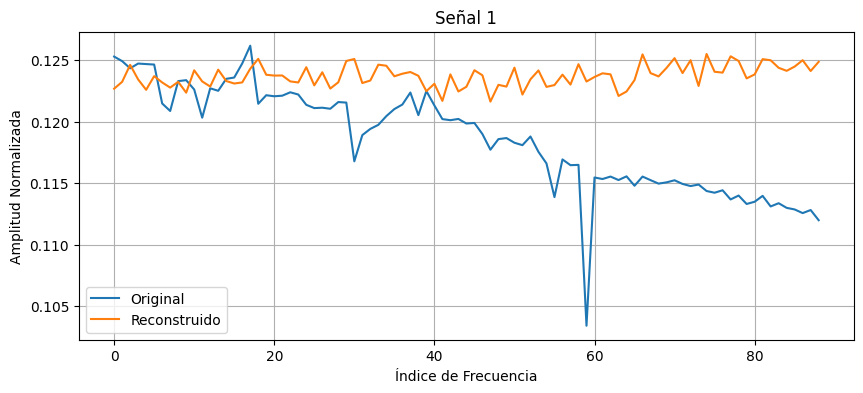

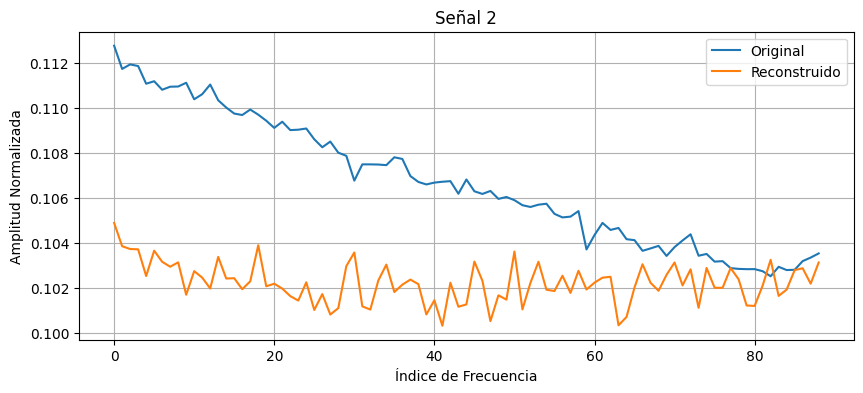

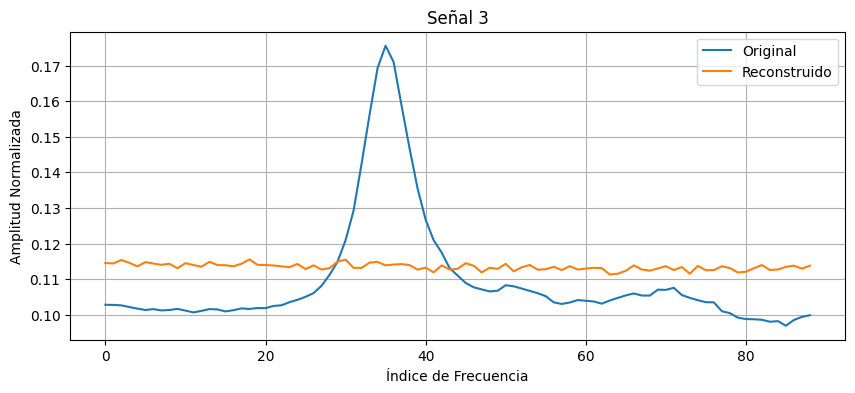

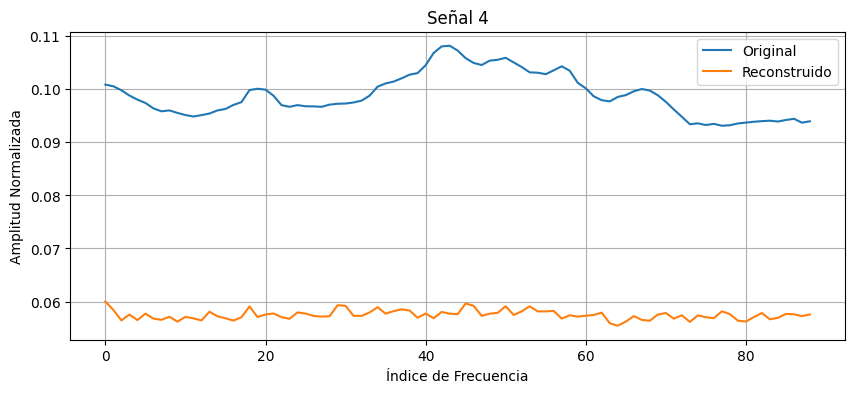

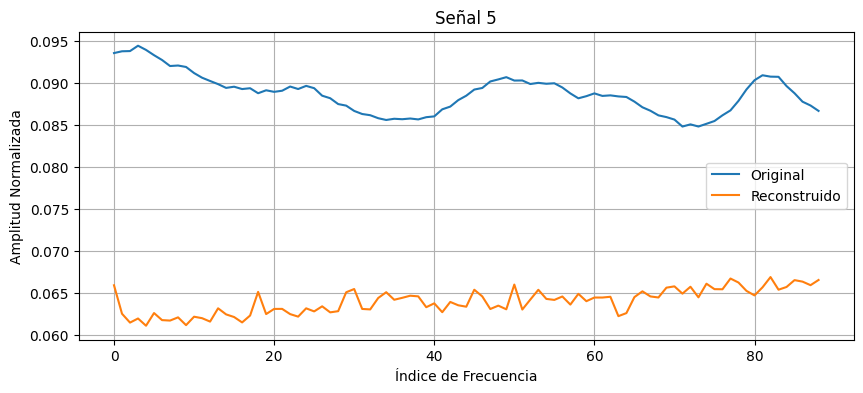

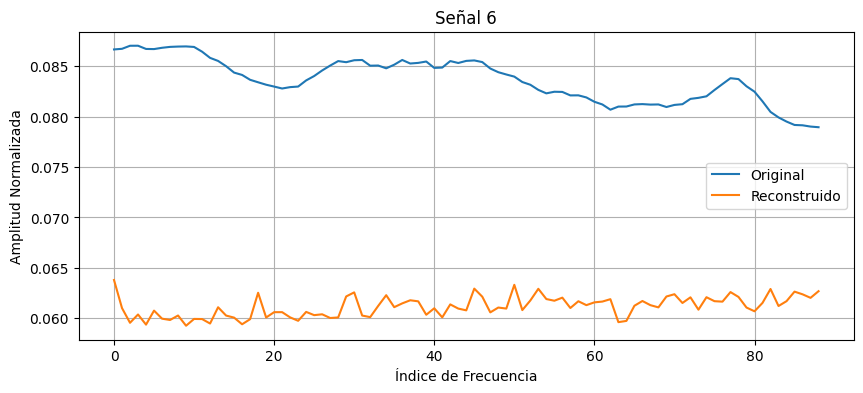

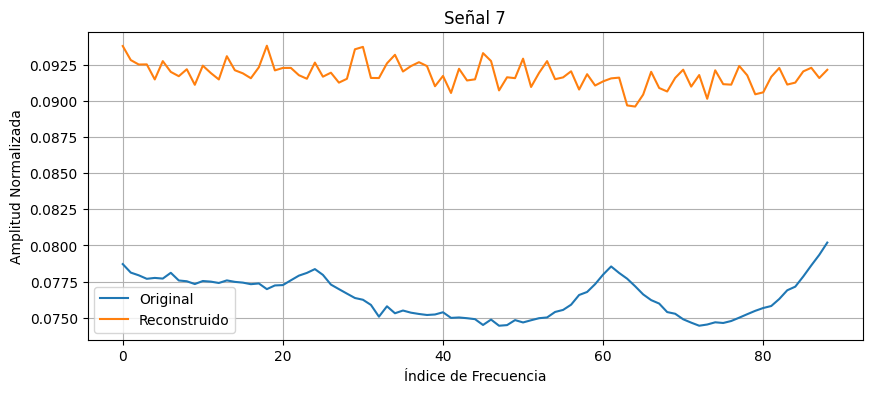

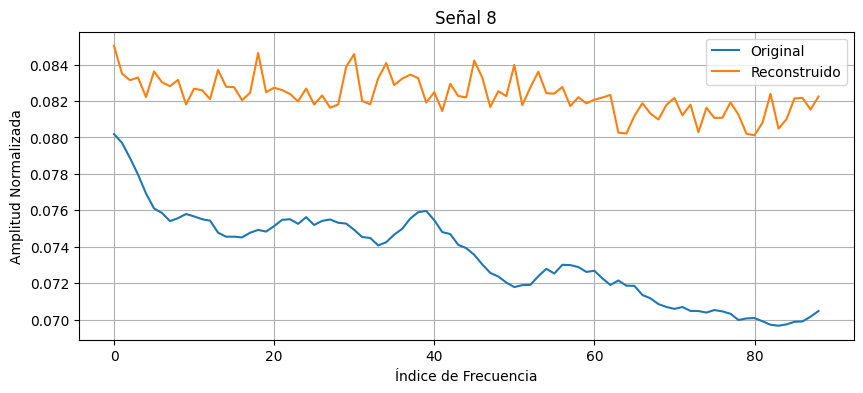

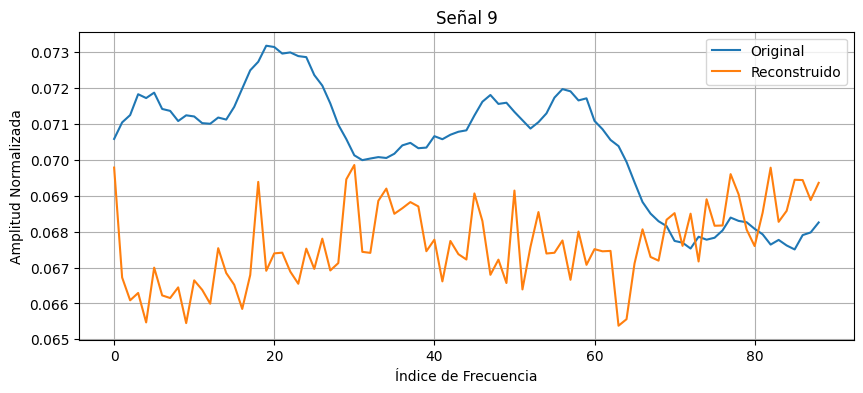

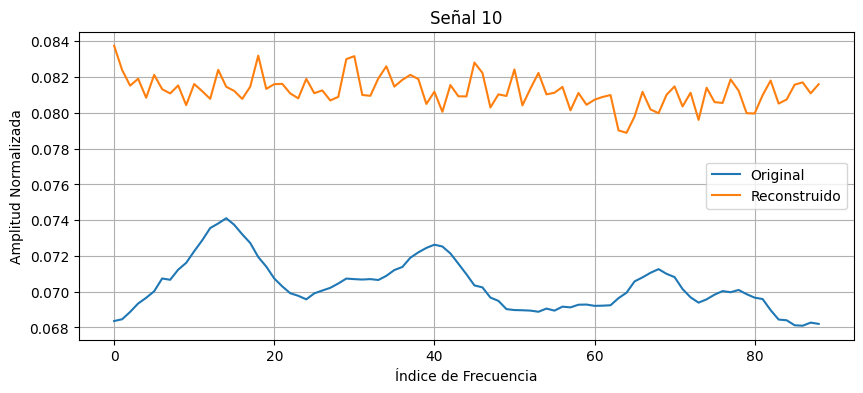

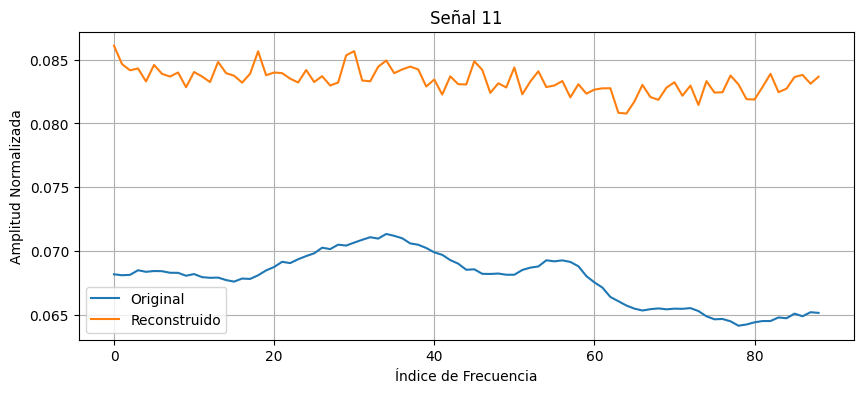

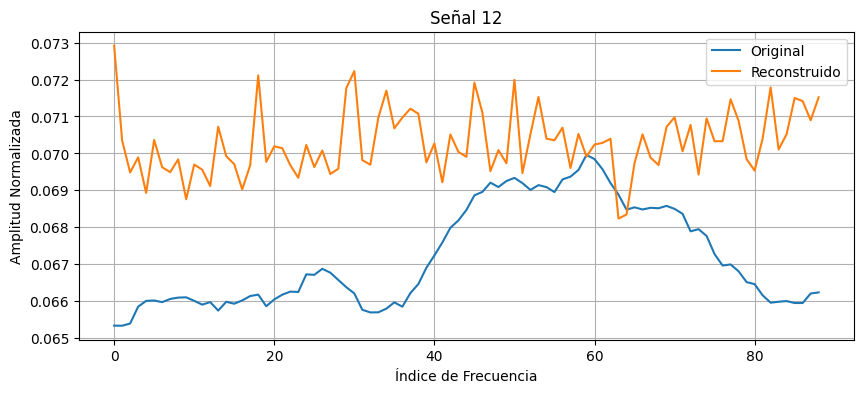

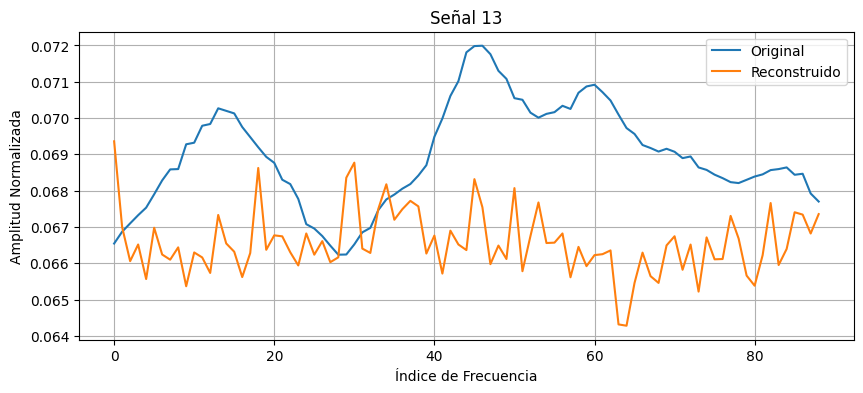

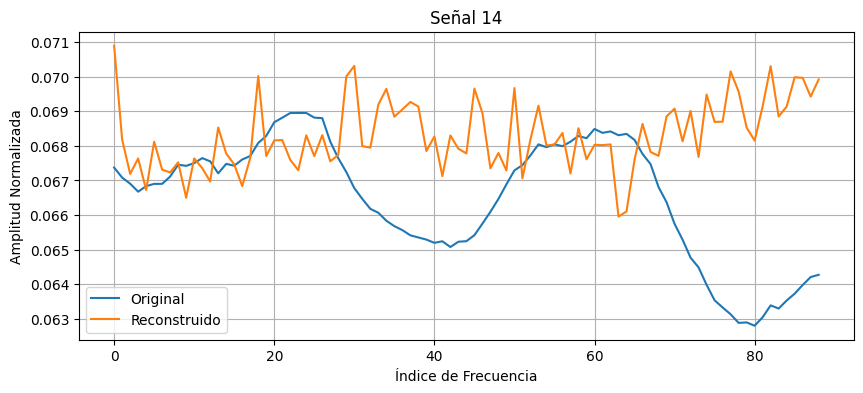

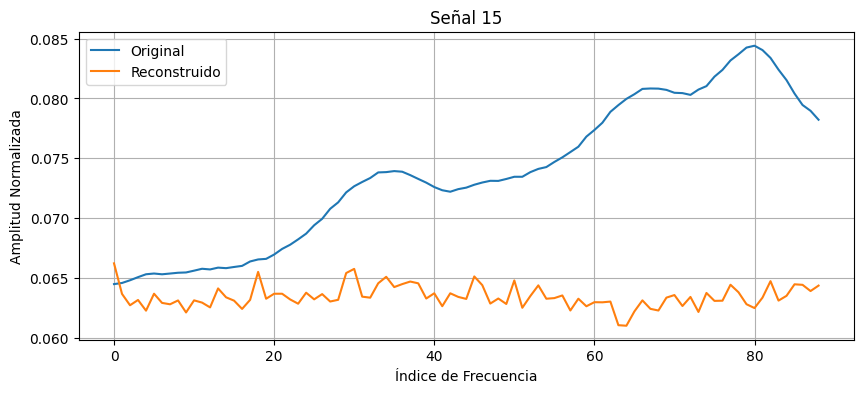

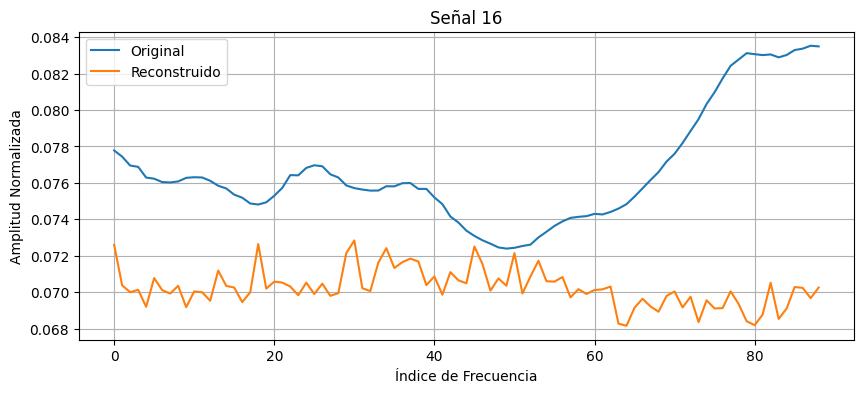

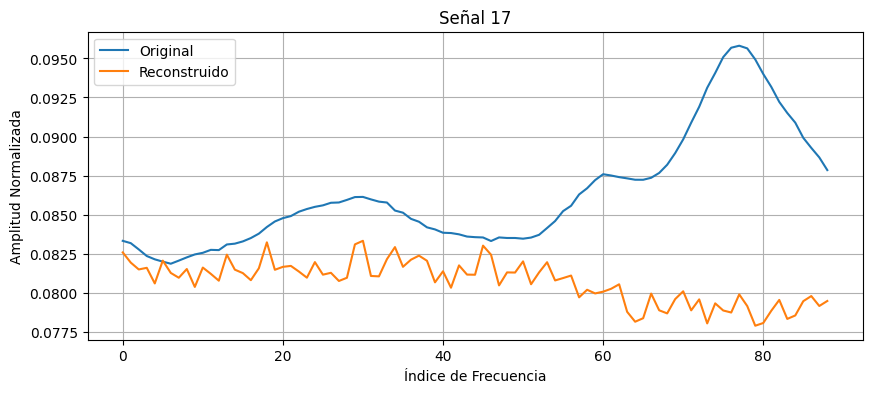

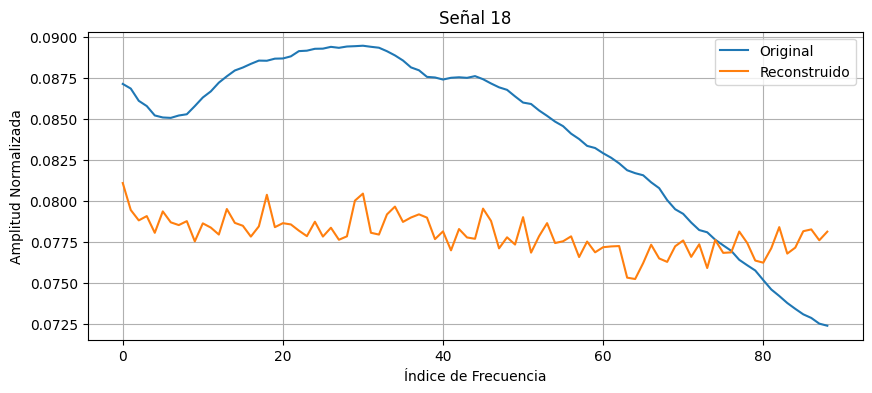

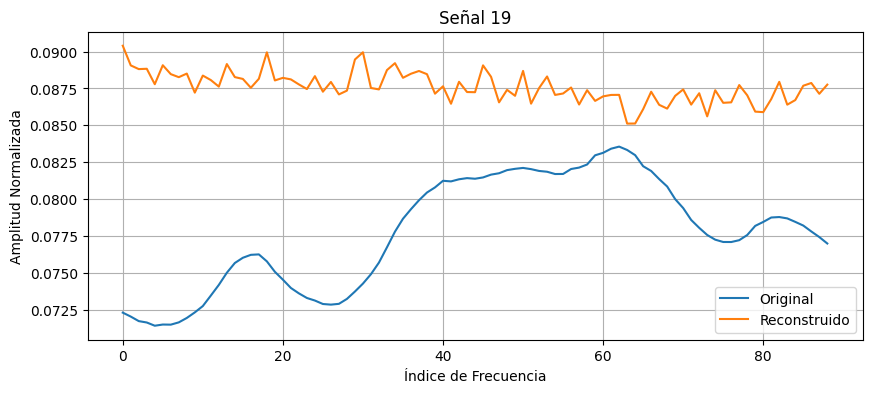

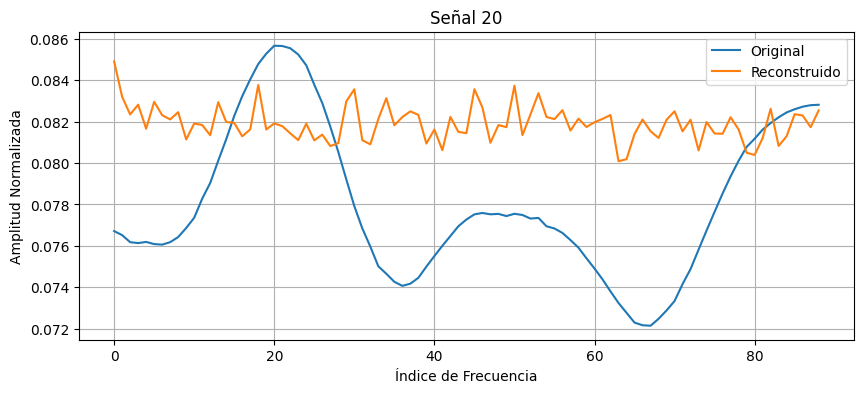

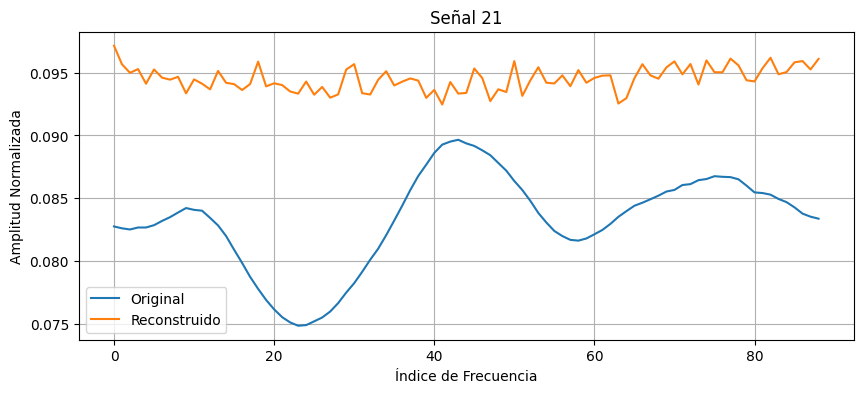

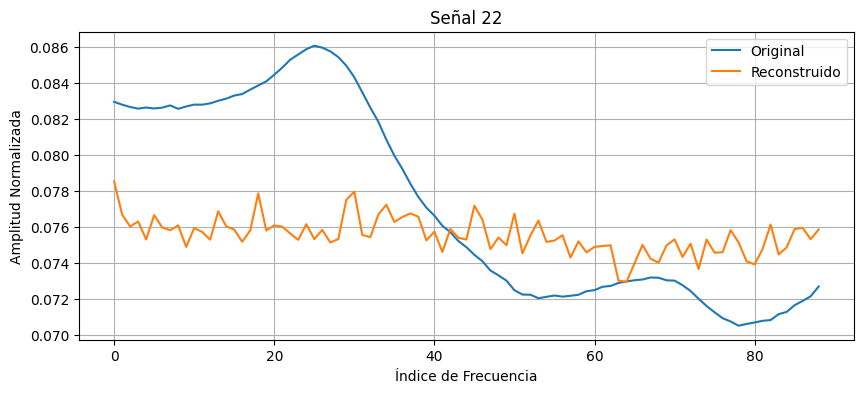

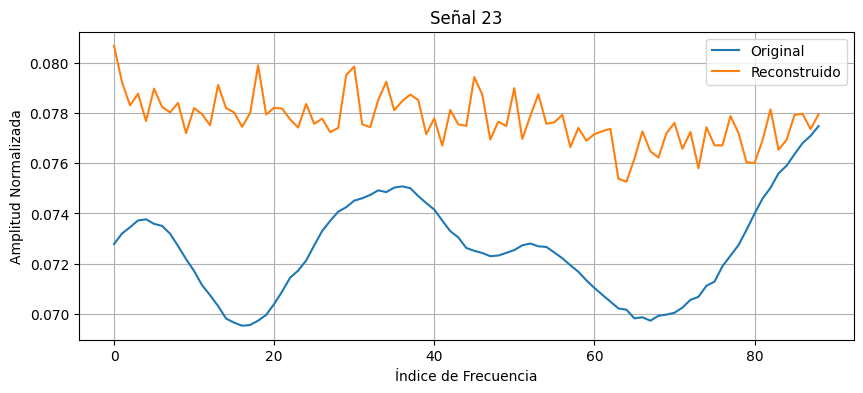

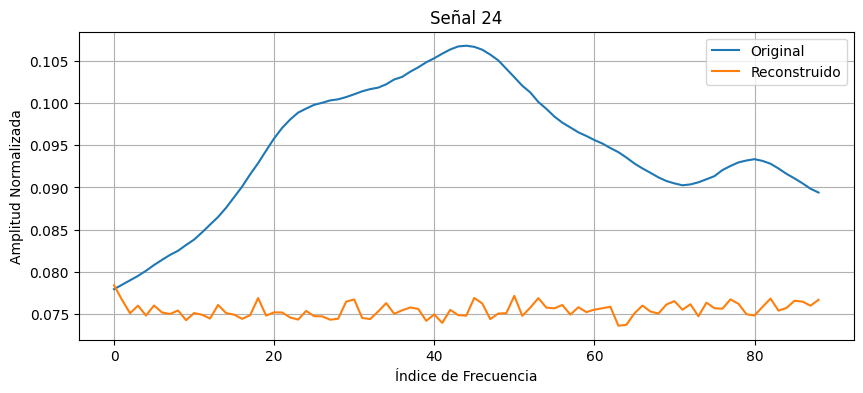

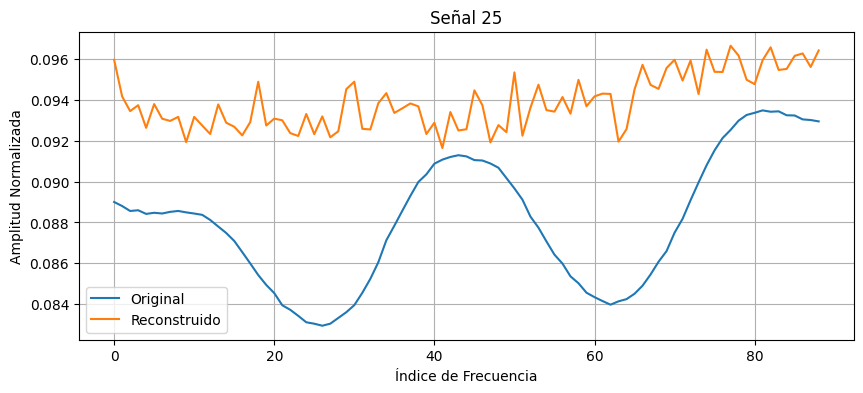

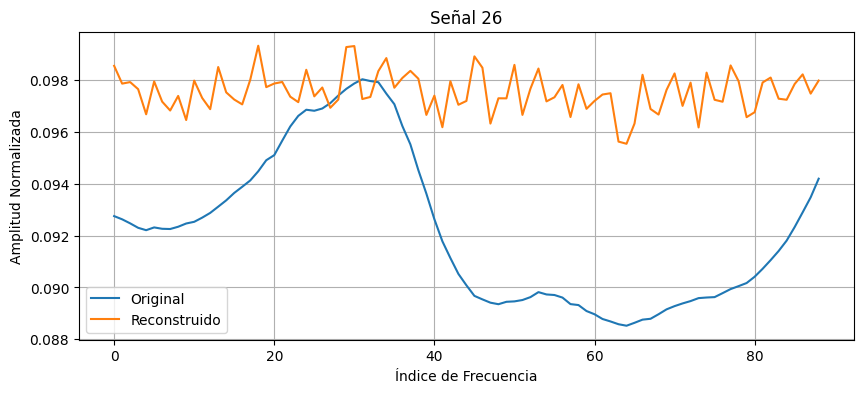

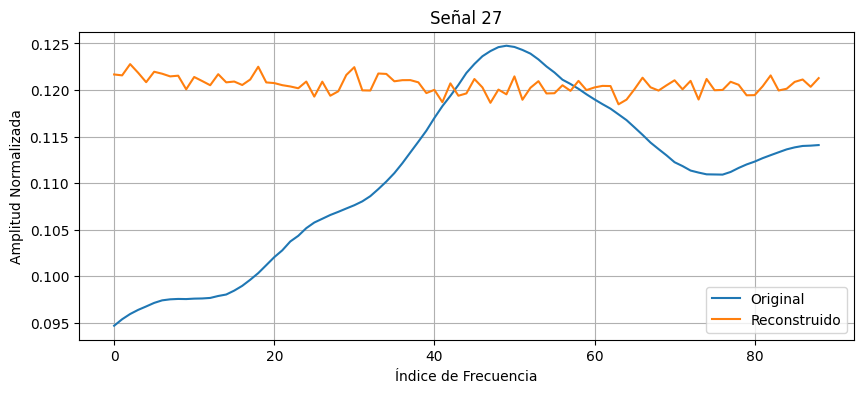

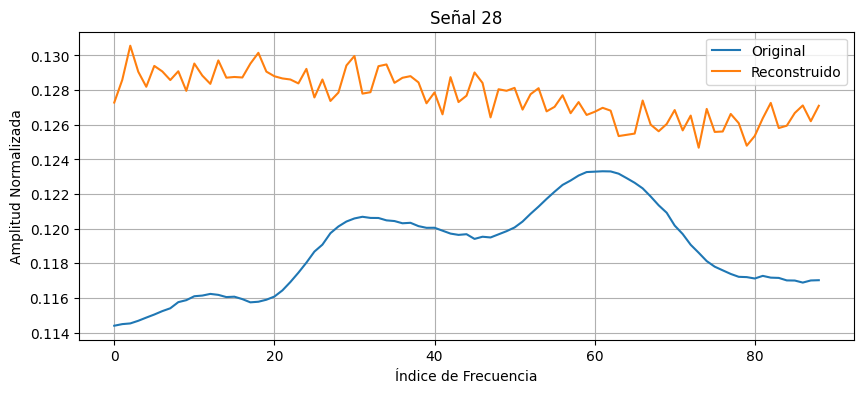

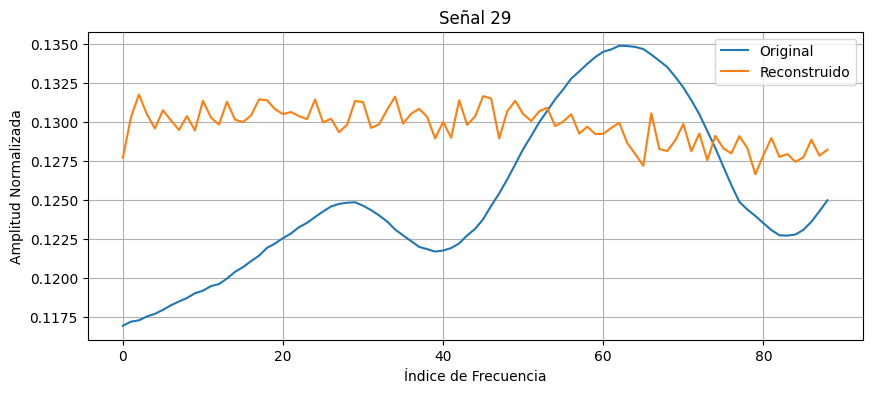

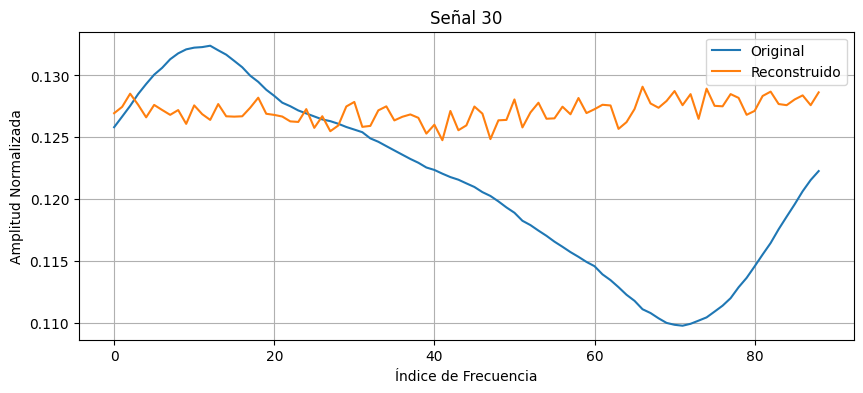

In [35]:
def evaluate_test_signals(model, test_data):
    model.eval()
    with torch.no_grad():
        for i, test_signal in enumerate(test_data[:30]):
            input_tensor = test_signal.unsqueeze(0)  # [1, 1, 89]
            reconstructed = model(input_tensor)[0].squeeze().detach()  # [89]

            plt.figure(figsize=(10, 4))
            plt.plot(test_signal.squeeze().numpy(), label='Original')
            plt.plot(reconstructed.numpy(), label='Reconstruido')
            plt.title(f"Señal {i+1}")
            plt.legend()
            plt.xlabel("Índice de Frecuencia")
            plt.ylabel("Amplitud Normalizada")
            plt.grid(True)
            plt.show()

evaluate_test_signals(model, loads_scaled)